# Libraries and Settings

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import Data

In [67]:
!ls -l ../data

total 872040
drwxr-xr-x@ 10 ting  staff        320 Mar 14 16:41 ACS_zip
-rw-r--r--@  1 ting  staff     361532 Apr  3 13:40 Neighborhood_Zri_MultiFamilyResidenceRental.csv
-rw-r--r--@  1 ting  staff      28694 Mar 19 18:05 State_Zri_AllHomesPlusMultifamily.csv
-rw-r--r--@  1 ting  staff    7472488 Mar 14 16:33 Zip_Zri_AllHomesPlusMultifamily.csv
-rw-r--r--@  1 ting  staff     891080 Apr  3 13:40 Zip_Zri_MultiFamilyResidenceRental.csv
-rw-r--r--@  1 ting  staff      28485 Mar 13 00:38 acs_datadict.xlsx
-rw-r--r--@  1 ting  staff  420362388 Apr  5 09:18 homezip-000000000000.csv
-rw-r--r--@  1 ting  staff       1345 Apr  1 23:01 kmeans_group.csv
-rw-r--r--@  1 ting  staff    1090357 Apr  2 18:41 nyu-2451-34509-geojson.json


In [121]:
raw = pd.read_csv('../data/Zip_Zri_MultiFamilyResidenceRental.csv')
raw.columns = raw.columns.str.replace('RegionName', 'zip')
raw.shape

(1861, 120)

In [122]:
raw_region = raw.iloc[:,:7].set_index('zip')
# raw_data = pd.concat([raw['zip'],raw.iloc[:,11+36:-1]],axis=1).set_index('zip') # 2014-2019
raw_data = pd.concat([raw['zip'],raw.iloc[:,11:-1]],axis=1).set_index('zip') # 2011-2019

# Data Cleaning

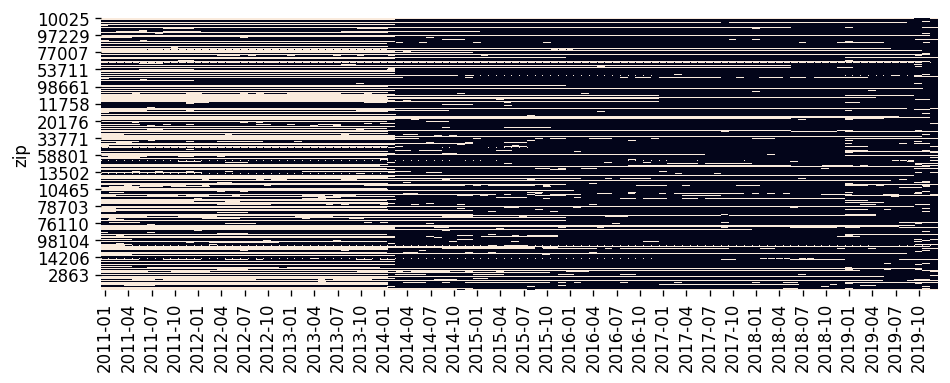

In [123]:
sns.heatmap(raw_data.isna(),cbar=False)

A lot of areas don't have data before 2014. ACS and IRS data are from 2011-2017. If you choose to use data from 2014-2019, you can include more areas. If you choose to use data from 2011-2019, there are less areas but more historical data that can be used to train the model.

(array([578., 131.,  82.,  32.,  28.,  20., 141., 324.,  52.,  47.,  23.,
         52.,  11.,  27.,   7.,  17.,  38.,  31.,  93., 127.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

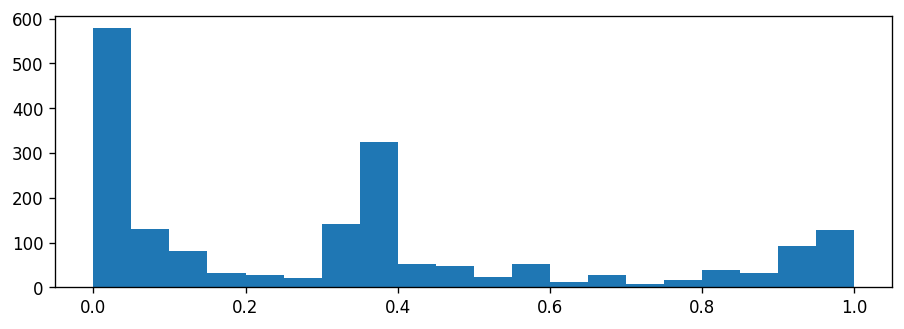

In [124]:
plt.hist(raw_data.isna().mean(axis=1),bins=20)

In [125]:
good = raw_data.isna().mean(axis=1) < 0.2
region = raw_region[good]
data = raw_data[good]
data.shape

(823, 108)

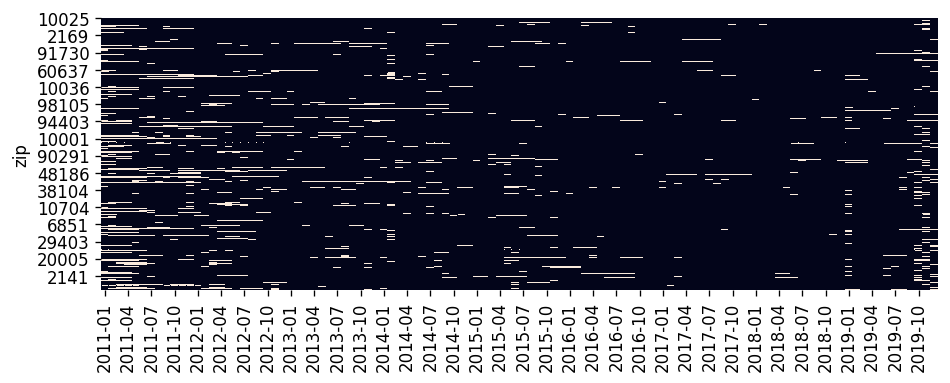

In [126]:
sns.heatmap(data.isna(),cbar=False)

In [127]:
apt = data.interpolate(method='linear',limit_direction='both', axis=1)

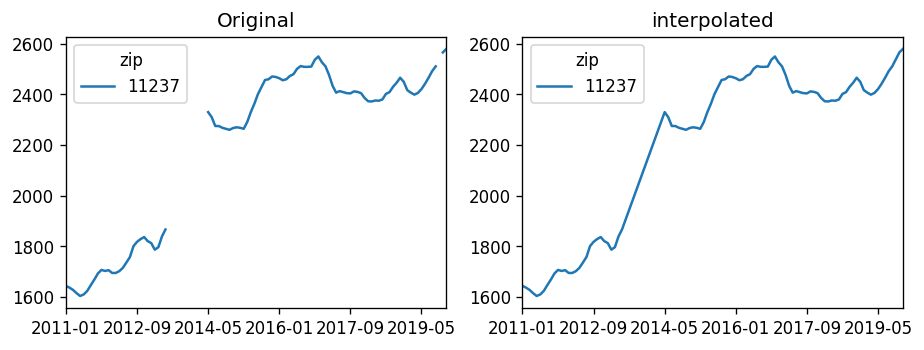

In [128]:
def plot_interpolate(zipcode):
    plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
    fig, axes = plt.subplots(1, 2)
    data[data.index==zipcode].T.plot(ax=axes[0])
    axes[0].set_title('Original')
    apt[apt.index==zipcode].T.plot(ax=axes[1])
    axes[1].set_title('interpolated')
    
plot_interpolate(11237)

In [129]:
def get_stat(region,raw_region):
    city = pd.DataFrame(region['City'].value_counts())
    city_raw = pd.DataFrame(raw_region['City'].value_counts())
    stat = pd.concat([city,city_raw],axis=1,sort=False)
    stat = stat.fillna(0)
    stat.columns = ['clean','raw']
    stat = stat.sort_values('raw',ascending=False)
    stat['ratio'] = stat['clean']/stat['raw']
    return(stat)

stat = get_stat(region,raw_region)

In [134]:
stat.sort_values('clean',ascending=False)

,clean,raw,ratio
New York,138.0,150,0.920000
Los Angeles,35.0,54,0.648148
Chicago,30.0,45,0.666667
Boston,20.0,24,0.833333
Buffalo,13.0,14,0.928571
...,...,...,...
Mount Rainier,0.0,1,0.000000
Dana Point,0.0,1,0.000000
West Seneca,0.0,1,0.000000
Junction City,0.0,1,0.000000


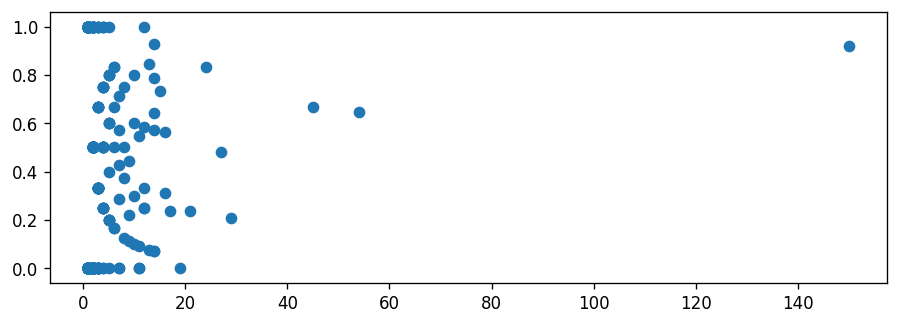

In [130]:
plt.scatter(stat['raw'],stat['ratio'])

# Previous Work

In [135]:
month = ['01','02','03','04','05','06','07','08','09','10','11','12']
year = '2012'
col_month = [year+'-'+m for m in month]
col = ['RegionName'] + col_month

In [136]:
zri = raw_zri[col].set_index('RegionName')

In [137]:
zri.head()

,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12
RegionName,,,,,,,,,,,,
10025,2962.0,2980.0,2995.0,3014.0,3017.0,3045.0,3083.0,3124.0,3161.0,3157.0,3184.0,3234.0
60657,1494.0,1497.0,1497.0,1505.0,1518.0,1526.0,1541.0,1562.0,1570.0,1579.0,1582.0,1589.0
10023,2841.0,2869.0,2888.0,2904.0,2909.0,2932.0,2958.0,2972.0,2967.0,2966.0,2984.0,2994.0
77494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60614,1569.0,1571.0,1576.0,1585.0,1589.0,1593.0,1607.0,1624.0,1628.0,1650.0,1661.0,1680.0


In [168]:
zri = zri.dropna(how='all')

In [169]:
zri['valid'] = np.sum(zri.notna(),axis=1)

In [170]:
zri['zri_ave'] = np.sum(zri[col_month],axis=1)/zri['valid']

In [171]:
zri

,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,valid,zri_ave
RegionName,,,,,,,,,,,,,,
10025,2905.0,2916.0,2908.0,2915.0,2920.0,2920.0,2938.0,2999.0,3029.0,3022.0,3049.0,3083.0,12,2967.000000
60657,1820.0,1818.0,1829.0,1843.0,1860.0,1878.0,1898.0,1889.0,1890.0,1894.0,1897.0,1886.0,12,1866.833333
10023,2988.0,3023.0,3037.0,3055.0,3069.0,3058.0,3065.0,3104.0,3117.0,3118.0,3124.0,3128.0,12,3073.833333
77494,1606.0,1614.0,1617.0,1612.0,1611.0,1617.0,1630.0,1640.0,1649.0,1655.0,1658.0,1658.0,12,1630.583333
60614,1950.0,1945.0,1956.0,1980.0,1989.0,2012.0,2021.0,2021.0,2035.0,2076.0,2093.0,2098.0,12,2014.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92341,1193.0,1193.0,1191.0,1188.0,1181.0,1174.0,1156.0,1153.0,1159.0,1162.0,1163.0,1162.0,12,1172.916667
26291,890.0,914.0,926.0,934.0,927.0,921.0,926.0,NaN,984.0,995.0,1006.0,1022.0,11,949.545455
12720,1149.0,1134.0,1128.0,1113.0,1100.0,1104.0,NaN,1171.0,1188.0,1200.0,1197.0,1190.0,11,1152.181818


In [172]:
acs = pd.read_csv('../data/ACS_zip/zip_codes_2011.csv')

In [173]:
acs.shape

(33120, 252)

In [174]:
data = acs.merge(zri_2011.reset_index(),left_on='geo_id',right_on='RegionName',how='inner')

In [175]:
data.shape

(11937, 267)

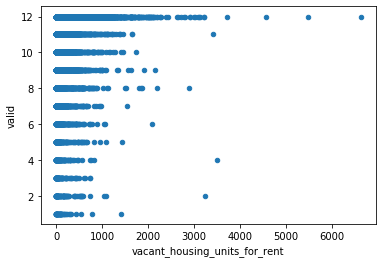

In [177]:
data.plot.scatter('vacant_housing_units_for_rent','valid')

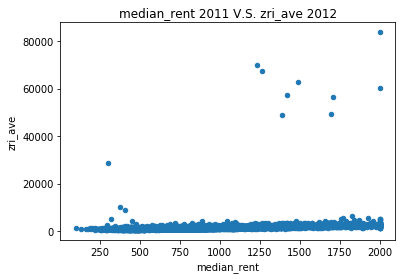

In [186]:
data.plot.scatter('median_rent','zri_ave',title = 'median_rent 2011 V.S. zri_ave 2012')

In [188]:
zri[zri['zri_ave'] > 20000]

,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,valid,zri_ave
RegionName,,,,,,,,,,,,,,
11937,NaN,NaN,NaN,NaN,56051.0,55802.0,55409.0,NaN,NaN,NaN,NaN,NaN,3,55754.000000
11978,NaN,NaN,NaN,63783.0,65107.0,65277.0,64920.0,NaN,NaN,NaN,NaN,NaN,4,64771.750000
11942,NaN,NaN,NaN,NaN,NaN,NaN,59772.0,NaN,NaN,NaN,NaN,NaN,1,59772.000000
11976,NaN,NaN,NaN,69137.0,70385.0,71220.0,71705.0,NaN,NaN,NaN,NaN,NaN,4,70611.750000
11977,NaN,NaN,NaN,67548.0,68741.0,68529.0,67945.0,NaN,NaN,NaN,NaN,NaN,4,68190.750000
11930,NaN,NaN,NaN,NaN,65660.0,65603.0,64625.0,NaN,NaN,NaN,NaN,NaN,3,65296.000000
11959,NaN,52853.0,53769.0,54258.0,54561.0,54560.0,53679.0,NaN,NaN,NaN,NaN,NaN,6,53946.666667
11932,NaN,NaN,NaN,NaN,78358.0,78528.0,76974.0,NaN,NaN,NaN,NaN,NaN,3,77953.333333
11960,NaN,80437.0,79587.0,79106.0,79724.0,80229.0,80304.0,NaN,NaN,NaN,NaN,NaN,6,79897.833333


In [192]:
raw_zri.loc[raw_zri['RegionName'].isin(zri[zri['zri_ave'] > 20000].index),:]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
3406,62287,11937,East Hampton,NY,New York-Newark-Jersey City,Suffolk County,3407,6853.0,NaN,NaN,...,25789.0,25628.0,25426.0,25581.0,25629.0,25763.0,NaN,23331.0,24018.0,24675.0
9894,62323,11978,Westhampton Beach,NY,New York-Newark-Jersey City,Suffolk County,9895,8976.0,9160.0,9099.0,...,21732.0,21914.0,22025.0,22018.0,21828.0,21338.0,NaN,20354.0,NaN,20672.0
10133,62291,11942,East Quogue,NY,New York-Newark-Jersey City,Suffolk County,10134,6738.0,NaN,7019.0,...,18493.0,18377.0,17980.0,17487.0,NaN,NaN,NaN,NaN,15105.0,NaN
11497,62321,11976,Water Mill,NY,New York-Newark-Jersey City,Suffolk County,11498,19642.0,NaN,NaN,...,33261.0,33854.0,34439.0,35055.0,35626.0,36182.0,NaN,34372.0,33478.0,32932.0
11755,62322,11977,Westhampton,NY,New York-Newark-Jersey City,Suffolk County,11756,9751.0,9843.0,9736.0,...,21487.0,21636.0,21713.0,21707.0,21502.0,21070.0,NaN,19490.0,19136.0,NaN
12065,62281,11930,Amagansett,NY,New York-Newark-Jersey City,Suffolk County,12066,6812.0,NaN,NaN,...,28447.0,28474.0,28512.0,28772.0,29172.0,29231.0,NaN,NaN,27062.0,26319.0
12663,62306,11959,Quogue,NY,New York-Newark-Jersey City,Suffolk County,12664,31054.0,30453.0,NaN,...,25929.0,26166.0,26648.0,26766.0,26687.0,26666.0,26232.0,25908.0,26662.0,25994.0
12681,62283,11932,Bridgehampton,NY,New York-Newark-Jersey City,Suffolk County,12682,9736.0,9748.0,NaN,...,32767.0,32610.0,32291.0,31883.0,31999.0,32152.0,NaN,29904.0,29975.0,29973.0
13099,62307,11960,Remsenburg,NY,New York-Newark-Jersey City,Suffolk County,13100,22971.0,NaN,26735.0,...,25304.0,25634.0,25901.0,25940.0,25515.0,24847.0,24859.0,NaN,23339.0,NaN


In [183]:
features = ['total_pop','median_age','households','median_income','income_per_capita','housing_units',
            'vacant_housing_units','vacant_housing_units_for_rent','vacant_housing_units_for_sale',
           'median_rent','percent_income_spent_on_rent']